# Activity 4.1. EM for GMM

(last modified 30 August 2023)

## Learning Outcomes

In this activity you will learn to:
- Generate Symmetric Positive-Definite Matrices
- Explore Unsupervised Learning Models, specifically Gasussian Mixture Models
- Explore the differences between Hard and Soft Expectation Maximimization


## Prerequisites

- Module 3
- Lecture 7

## Soft EM for GMM

Given some collection of data $X = \{x_1, ... x_n\}$ and labels with one-to-one correspondance to X, $Z=\{z_1, ... z_n\}$, we can call X the Incomplete Data and $D=(X, Z)$ the Complete Data. We assume that Z is categorical data that can fall into one of K categories. The goal of Expectation Maximisation algorithms is to learn the correspondance between X and Z without having access to Z, and generalise this correspondance to unobserved data. As such, Expectation Maximisation algorithms are a form of unsupervised learning. 

Expectation-Maximisation algorithms follow the following structure:
1. Repeat until convergence or maximum iterations exceeded:
2. Use a surrogate model to compute a guess for the labels $\hat{z_k}$
3. Fit a surrogate model to X and the current best guesses by solving for the Maximum Likelihood Estimates for the model hyperparameters' log likelihood (Refer to Week 7 Slides for more information). 

In this activity, we will be looking at two variants of Gaussian Mixture Models, and our model parameters $\mu$ and $\Sigma$ can be estimated with the following model equations:

\begin{equation}
\mu_k^{(i+1)} = \frac{\sum_{n=1}^N x_n r_{n, k}}{\sum_{i=1}^N r_{n,k}}
\end{equation}

\begin{equation}
\Sigma_k^{(i+1)} = \frac{\sum_{n=1}^N r_{n, k} (x_n - \mu_k^{(i+1)})(x_n - \mu_k^{(i+1)})^T}{\sum_{i=1}^N r_{n,k}}
\end{equation}

And predictions for the probability of each class $r_{n, k}$ can be drawn from it's associated multivariate normal distribution
\begin{equation}
r_{n, k} = \hat{\psi}_k \Phi(X)
\end{equation}
 
\begin{equation}
\Phi(X) \sim N(\hat{\mu}_k, \Sigma_k)
\end{equation} 

\begin{equation}
\hat{\psi}_k =  \frac{\sum_{i=1}^N r_{n, k}}{N}
\end{equation}

(Refer to Week 8 Slides for more information)

Note that SoftEM algorithms predict a probability distribution across all classes. 

## Synthetic Data Generation

In this lab we will be making use of the make_gaussian_mixture_data function from Activity 3 to sample data from a Gaussian Mixture. 

### Task A: Sample and Plot Data [10 Minutes]

Consider the following datasets which we will be using for the duration of this lab. What do you notice about them? How are they different?

In [1]:
import numpy as np
from Activity4 import make_gaussian_mixture_data
import matplotlib.pyplot as plt

def plot_scatter_by_label(X, y, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        fig.set_figheight(6)
        fig.set_figwidth(8)
    categories = np.unique(y)
    for cat in categories:
        ax.scatter(X[y==cat, 0], X[y==cat, 1], label='Cluster {0}'.format(cat), alpha=0.25)
        ax.scatter(np.mean(X[y==cat, 0]), np.mean(X[y==cat, 1]), c='k', marker='x', s=200)
    ax.set_xlabel('X0', size=15)
    ax.set_ylabel('X1', size=15)
    ax.set_title(title if title else "Gaussian Mixture", size=20)
    plt.legend()
    return ax

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Non Separable Data'}, xlabel='X0', ylabel='X1'>

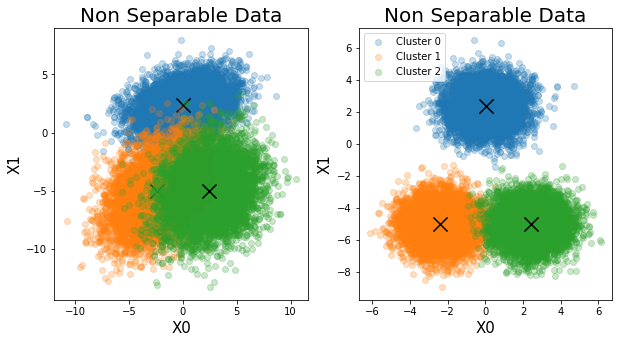

In [2]:
mu0 = 5*np.array([0, np.arctan(np.pi/6)])
mu1 = 5*np.array([np.arctan(-np.pi/6), -1])
mu2 = 5*np.array([np.arctan(np.pi/6), -1])

cov0 = np.array([[5, 1], [1, 2]])
cov1 = np.array([[5, 2], [2, 5]])
cov2 = np.array([[5, 1], [1, 5]])

means = [mu0, mu1, mu2]

covs = [cov0, cov1, cov2]

class_probs = np.array([1, 1, 1])/3

N = 20000
K=3

X_train, y_train = make_gaussian_mixture_data(n=N, means=means, covs=covs, class_probs=class_probs, random_state=0)
X_test, y_test = make_gaussian_mixture_data(n=10000, means=means, covs=covs, class_probs=class_probs, random_state=0)

X_train_sep, y_train_sep = make_gaussian_mixture_data(n=N, means=means, covs=None, class_probs=class_probs, random_state=0)
X_test_sep, y_test_sep = make_gaussian_mixture_data(n=10000, means=means, covs=None, class_probs=class_probs, random_state=0)

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.set_figheight(5)
plot_scatter_by_label(X_train, y_train, ax=axs[0], title='Non Separable Data')
plot_scatter_by_label(X_train_sep, y_train_sep, ax=axs[1], title='Non Separable Data')

### Task B: Implement and predict_proba for SoftEM

Complete the following functions:

The fit function attempts to separate the data into K subgroups, each of which can be fitted to a multivariate normal. This split is iteratively updated with the goal of creating a cleaner split in the data, which can be better fitted to a multivariate normal. 

The predict_proba function maps input data to a probability mass for each of the K classes fitted. 

Note that self.r_historic_ and self.Mu_hat_historic_ are being used to track the intermediate steps of the fitting process. This is not necessary for the algorithm but will be useful later to create some visualisations. 



In [3]:
from scipy.stats import multivariate_normal
class SoftGMM: 
    def __init__(self, K, tau_max=200, epsilon=0.01, random_state=None):
        self.K = K               # number of GMM clusters
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon  # minimum acceptable error rate
        self.random_state = random_state
        np.random.seed(self.random_state)

    def get_params(self, deep=False):
        return {'K': self.K,
         'tau_max': self.tau_max,
         'epsilon': self.epsilon,
         'random_state': self.random_state}
    
    def __str__(self):
        params = self.get_params()
        return 'SoftGMM({0})'.format(','.join(['='.join([key, str(params[key])]) for key in params.keys()]))

    def __repr__(self):
        return self.__str__()
                
    def fit(self, X, verbose=False):
        N = X.shape[0]
        ## initialization:
        self.Psi_hat_ = np.array([1/self.K] * self.K)                         # assume all clusters have the same prob (we will update this later on)
        self.Nk_hat_ = self.Psi_hat_ * N                                       
        self.Mu_hat_ = X[np.random.choice(N, size=self.K, replace=False)]   # randomly  choose K samples as cluster means (any better idea?)
        self.Sigma_hat_ = np.array([np.eye(X.shape[1]) for _ in range(self.K)])     # create identity covariance matrices as initialization
        r = np.zeros((N,self.K))                                     # empty posterior matrix (the membership estimates will be stored here)                
        
        self.Mu_hat_historic_ = np.zeros(shape=(list(self.Mu_hat_.shape) + [self.tau_max]))
        self.r_historic_ = np.zeros(shape=(N, self.K, self.tau_max))

        terminate= False
        tau = 0
        # fitting loop - we iteratively take E and M steps until the termination criterion is met.
        Mu_hat_old = self.Mu_hat_ # Mu_hat_old is used to store the last iteration value for mu_hat
        while (not terminate):
            if verbose: print('iteration {0}'.format(tau))
            # E step:
            for k in range(self.K):

                ## calculate the posterior based on the estimated means,covariance and cluster size:
                r[:,k] = self.Psi_hat_[k] * multivariate_normal.pdf(X, mean=self.Mu_hat_[k], cov=self.Sigma_hat_[k])

            r = r/r.sum(axis=1,keepdims=True) # normalization (to make sure sum(r)=1)
            self.r_historic_[:, :, tau] = r

            # M step (note that we use the vectorised notation directly which is much better and faster than using a for loop):
            self.Nk_hat_ = r.sum(axis=0)
            self.Psi_hat_ = self.Nk_hat_/N
            self.Mu_hat_ = (r.T @ X)/ self.Nk_hat_.reshape((-1,1))
            self.Mu_hat_historic_[:, :, tau] = self.Mu_hat_
            # only Sigma must be calculated in a loop because it involves element wise multiplication with r
            for k in range(K):
                r_k = r[:,k,None]   #this None is to reshape the array to a singleton
                # apply formula
                self.Sigma_hat_[k] = 1/self.Nk_hat_[k] * ( (X - self.Mu_hat_[k]).T @ (r_k * (X - self.Mu_hat_[k])) )

            # increase iteration counter
            tau +=1

            # check termination condition
            terminate = ((tau == self.tau_max) or np.allclose(self.Mu_hat_, Mu_hat_old, rtol= self.epsilon))
            # record the means (neccessary for checking the termination criteria)
            Mu_hat_old = self.Mu_hat_

        self.Mu_hat_historic_ = self.Mu_hat_historic_[:, :, :tau]
        self.r_historic_ = self.r_historic_[:, :, :tau]

        if verbose: print(f'Converged in {tau} iterations')

        return self
        
        
    def predict_proba(self, x):
        N = x.shape[0]
        r = np.zeros((N,self.K))
        for k in range(self.K):
            ## calculate the posterior based on the estimated means,covariance and cluster size:
            r[:,k] = self.Psi_hat_[k] * multivariate_normal.pdf(x, mean=self.Mu_hat_[k], cov=self.Sigma_hat_[k])
        r = r/r.sum(axis=1,keepdims=True) # normalization (to make sure sum(r)=1)
        
        return r

    def predict(self, x):
        probs = self.predict_proba(x)
        preds = np.argmax(probs, axis=1)
        return preds


## Task C: Evaluate the Model

Let's use the self.r_historic_ and self.Mu_hat_historic_ variables to oberve how our model fit evolves during the fitting procedure.

- What do you notice as the number of iterations increases? 
- What differences do you see between the two datasets?

In [4]:
def plot_gmm(gmm, x, gran=3):
    # plotting every 10 iterations
    idxs = np.arange(start=0, stop=gmm.r_historic_.shape[-1], step=gran)
    n_plots = len(idxs)
    rows = int(np.sqrt(n_plots))
    cols = int(n_plots//rows) + 1
    fig, axs = plt.subplots(rows, cols)
    fig.set_figheight(5*rows)
    fig.set_figwidth(5*cols)
    for i, idx in enumerate(idxs):
        if not(1 in (rows, cols)):
            j = int(i//cols)
            k = int(i%cols)
            axs[j, k].scatter(x[:,0], x[:,1], c=gmm.r_historic_[:, :, idx], alpha=0.25) # coloring with r will create a mix of RGB colors based on posterior of each point
            axs[j, k].scatter(gmm.Mu_hat_historic_[:,0,idx], gmm.Mu_hat_historic_[:,1,idx], s=200, c='black', marker='x')
            axs[j, k].set_title('EM results (tau={0})'.format(idx))
            axs[j, k].set_xlabel('x1')
            axs[j, k].set_ylabel('x2')
        else:
            axs[i].scatter(x[:,0], x[:,1], c=gmm.r_historic_[:, :, idx], alpha=0.25) # coloring with r will create a mix of RGB colors based on posterior of each point
            axs[i].scatter(gmm.Mu_hat_historic_[:,0,idx], gmm.Mu_hat_historic_[:,1,idx], s=200, c='black', marker='x')
            axs[i].set_title('EM results (tau={0})'.format(idx))
            axs[i].set_xlabel('x1')
            axs[i].set_ylabel('x2')
    return fig, axs

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
Converged in 23 iterations


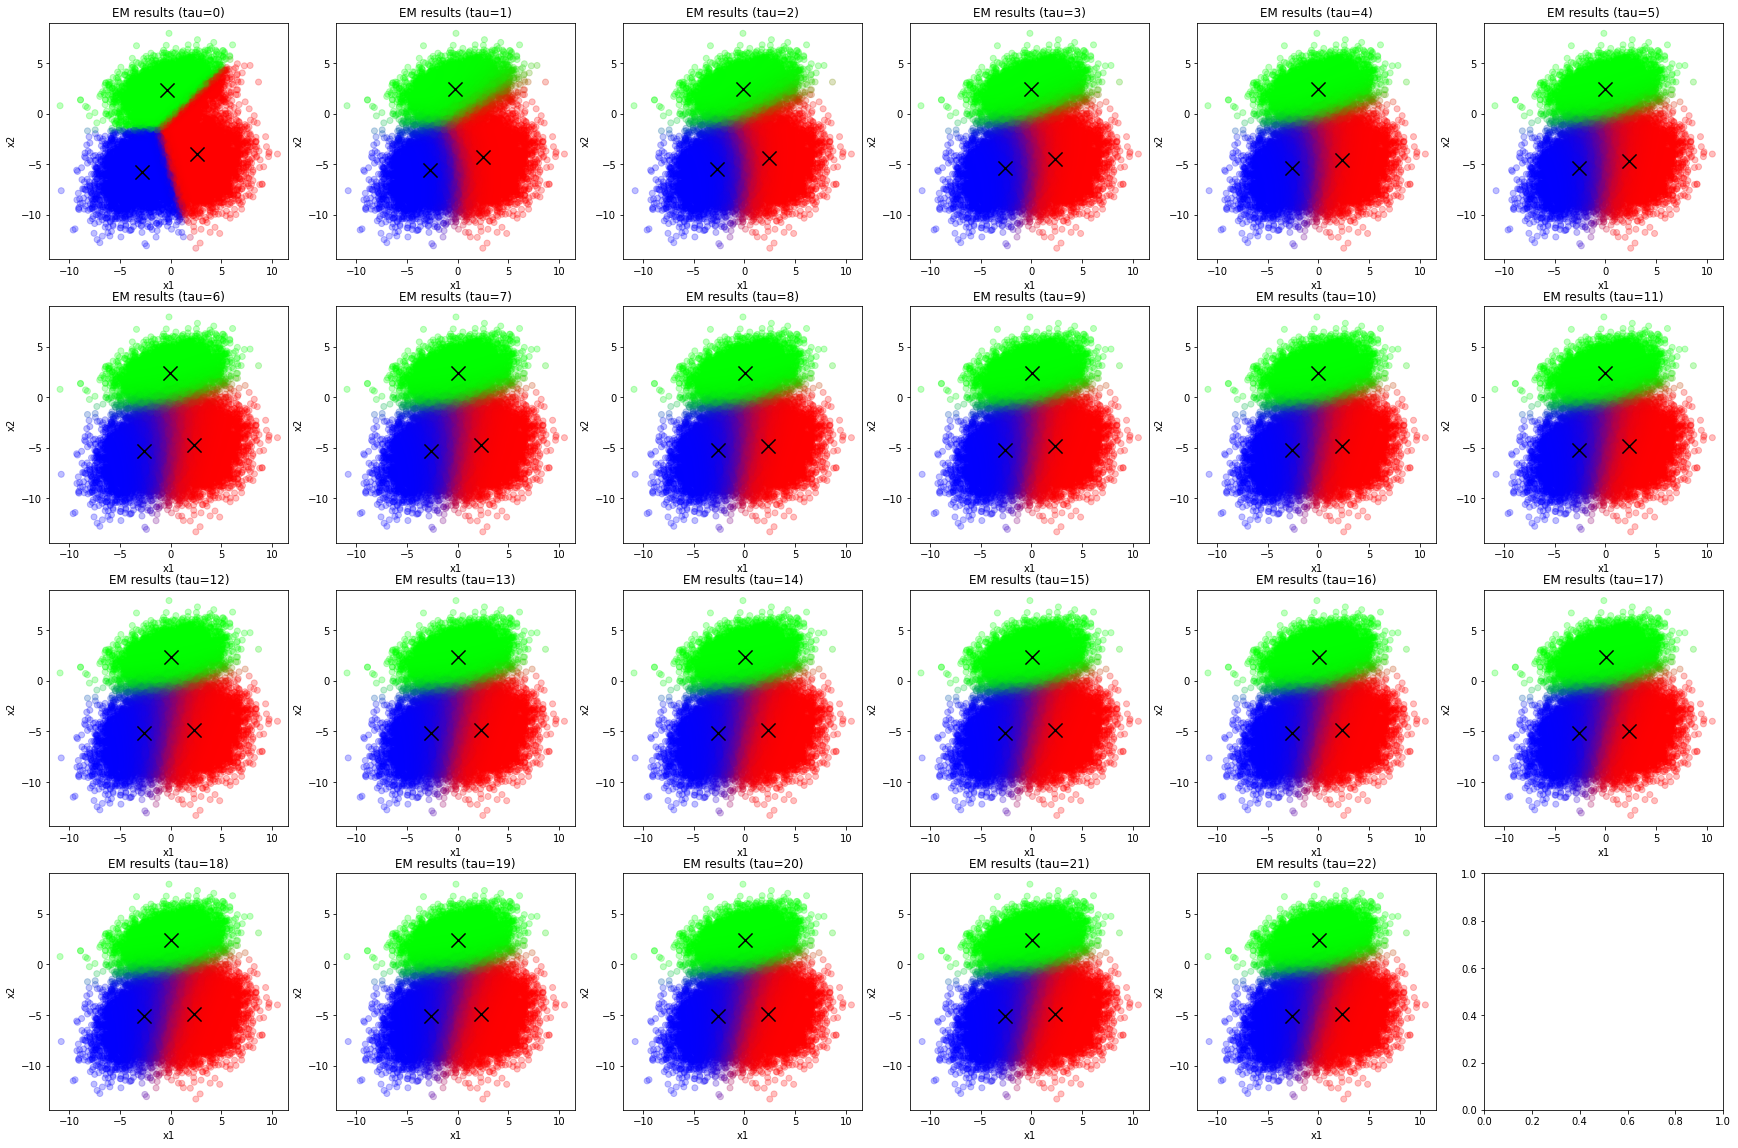

In [5]:
soft_gmm = SoftGMM(K=3, random_state=0)
soft_gmm.fit(X_train, verbose=True)
preds_proba = soft_gmm.predict_proba(X_test)  # soft cluster assignments
preds = soft_gmm.predict(X_test)  # soft cluster assignments
fig, axs = plot_gmm(soft_gmm, X_train, gran=1)
plt.show()

iteration 0
iteration 1
iteration 2
Converged in 3 iterations


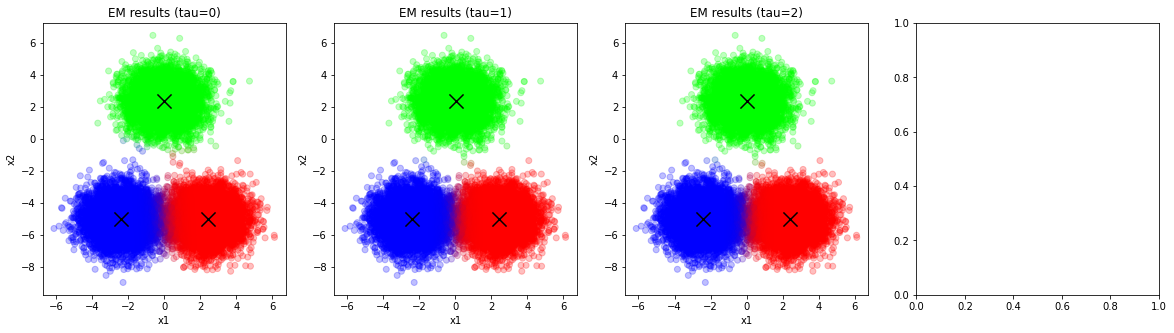

In [6]:
soft_gmm2 = SoftGMM(K=3, random_state=0)
soft_gmm2.fit(X_train_sep, verbose=True)
preds_proba = soft_gmm2.predict_proba(X_test_sep)  # soft cluster assignments
preds = soft_gmm2.predict(X_test_sep)  # soft cluster assignments
fig, axs = plot_gmm(soft_gmm2, X_train_sep, gran=1)
plt.show()

## Task D Plotting True Data against Predictions

We can also use plotting to check how well our model separates the data into the true clusters.

Complete the following function to create a scatter plot of our model's predictions on the various data samples we have. 

Based on the following plots, how well do you think the model generalises to unseen data? Is this plot sufficient evidence to support that claim? If not, what else could we do?

Note: The order of clusters, and hence their means, covariances, etc., may vary as EM has no idea about the real order of the clusters in the generation process. To make it easier to compare these values, you can sort them before comparing them.

/tmp/ipykernel_106605/2147363732.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Xs = np.array([[X_train, X_test, X_train_sep, X_test_sep], [X_train, X_test, X_train_sep, X_test_sep]])
/tmp/ipykernel_106605/2147363732.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys = np.array([[y_train, y_test, y_train_sep, y_test_sep],
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


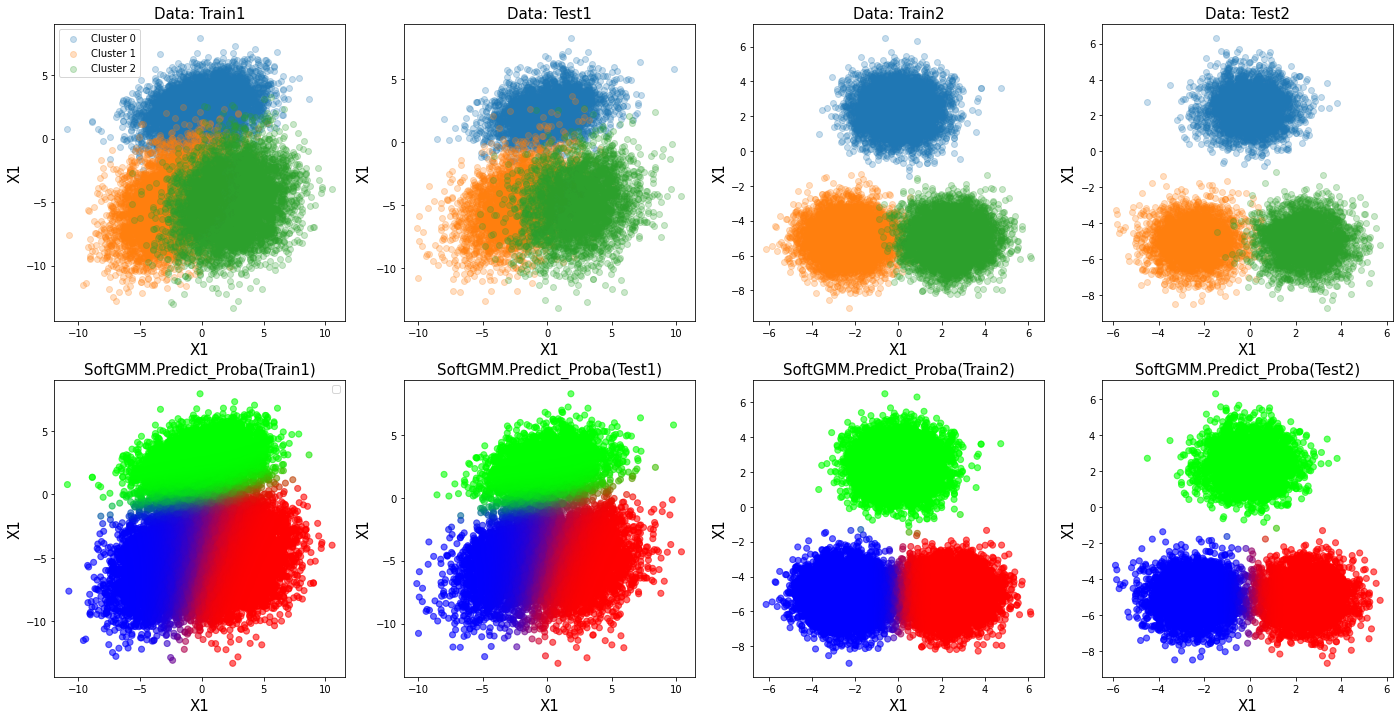

In [7]:
def plot_data_vs_predictions(Xs, ys, names):
    n, m = Xs.shape
    fig, axs = plt.subplots(n, m)
    fig.set_figwidth(m*6)
    fig.set_figheight(n*6)
    categories = np.unique(ys[0, 0])
    for i in range(Xs.shape[0]):
        for j in range(Xs.shape[1]):
            for cat in categories:
                if len(ys[i,j].shape) == 1: # plotting the true data
                    axs[i, j].scatter(Xs[i, j][ys[i, j]==cat, 0], Xs[i, j][ys[i, j]==cat, 1], label='Cluster {0}'.format(cat), alpha=0.25)
                else: # plotting model predictions
                    axs[i, j].scatter(Xs[i, j][:,0], Xs[i, j][:,1], c=ys[i, j], alpha=0.25) 
                axs[i, j].set_xlabel('X1', size=15)
                axs[i, j].set_ylabel('X1', size=15)
                axs[i, j].set_title(names[i, j], size=15)
            axs[i, 0].legend()
    return fig, axs

Xs = np.array([[X_train, X_test, X_train_sep, X_test_sep], [X_train, X_test, X_train_sep, X_test_sep]])
ys = np.array([[y_train, y_test, y_train_sep, y_test_sep], 
               [soft_gmm.predict_proba(X_train), soft_gmm.predict_proba(X_test), soft_gmm2.predict_proba(X_train_sep), soft_gmm2.predict_proba(X_test_sep)]])
fig, axs = plot_data_vs_predictions(Xs, ys, np.array([['Data: Train1', 'Data: Test1', 'Data: Train2', 'Data: Test2'], 
                                      ['SoftGMM.Predict_Proba(Train1)', 'SoftGMM.Predict_Proba(Test1)', 'SoftGMM.Predict_Proba(Train2)', 'SoftGMM.Predict_Proba(Test2)']]))
plt.show()

## Hard EM for GMM
In the above experiments, we implemented a SoftEM Gaussian Mixture Model. Now, we modify the code and develop a Hard EM for our GMM. 

In SoftEM we computed a probability distribution across all K classes for each datapoint, whereas in HardEM we simply take the class with the highest probability to be our best guess for the class of a datapoint. 

The vector $\hat{z_n}$ will be used to map our probability density for each class to a vector of all zeros, except at the index corresponding to the class with highest estimated probability, which will have a value of 1. 

\begin{equation}
\hat{z}_{n, k} = 1 \text{ if } k == \argmax(r_n) \text{ else } 0
\end{equation}

### Task E: Implement HardGMM [15 Minutes]

Complete the fit function for HardGMM. 

Hint: The max_clip_function should map a probability vector r to a zero-one vector where the only nonzero element is the most likely class. 

In [12]:
class HardGMM:
    def __init__(self, K, tau_max=200, epsilon=0.01, random_state=None):
        self.K = K               # number of GMM clusters
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon  # minimum acceptable error rate
        self.random_state = random_state
        np.random.seed(self.random_state)

    def get_params(self, deep=False):
        return {'K': self.K,
         'tau_max': self.tau_max,
         'epsilon': self.epsilon,
         'random_state': self.random_state}
    
    def __str__(self):
        params = self.get_params()
        return 'HardGMM({0})'.format(','.join(['='.join([key, str(params[key])]) for key in params.keys()]))

    def __repr__(self):
        return self.__str__()
                
    def fit(self, X, verbose=False):
        N = X.shape[0]
        ## initialization:
        self.Psi_hat_ = np.array([1/self.K] * self.K)                         # assume all clusters have the same prob (we will update this later on)
        self.Nk_hat_ = self.Psi_hat_ * N                                       
        self.Mu_hat_ = X[np.random.choice(N, size=self.K, replace=False)]   # randomly  choose K samples as cluster means (any better idea?)
        self.Sigma_hat_ = np.array([np.eye(X.shape[1]) for _ in range(self.K)])     # create identity covariance matrices as initialization
        r = np.zeros((N,self.K))                                     # empty posterior matrix (the membership estimates will be stored here)                
        
        self.Mu_hat_historic_ = np.zeros(shape=(list(self.Mu_hat_.shape) + [self.tau_max]))
        self.r_historic_ = np.zeros(shape=(N, self.K, self.tau_max))

        terminate= False
        tau = 0
        # fitting loop - we iteratively take E and M steps until the termination criterion is met.
        Mu_hat_old = self.Mu_hat_ # Mu_hat_old is used to store the last iteration value for mu_hat
        while (not terminate):
            if verbose: print('iteration {0}'.format(tau))
            # E step:
            for k in range(self.K):

                ## calculate the posterior based on the estimated means,covariance and cluster size:
                r[:,k] = self.Psi_hat_[k] * multivariate_normal.pdf(X, mean=self.Mu_hat_[k], cov=self.Sigma_hat_[k])

            max_clip_function = lambda x:  np.array([1 if i== x.argmax() else 0 for i in range(len(x))])
            z_n_hat = np.array(list(map(max_clip_function, r)), dtype='float32')
            r = z_n_hat
            self.r_historic_[:, :, tau] = z_n_hat

            # M step (note that we use the vectorised notation directly which is much better and faster than using a for loop):
            self.Nk_hat_ = r.sum(axis=0)
            self.Psi_hat_ = self.Nk_hat_/N
            self.Mu_hat_ = (r.T @ X)/ self.Nk_hat_.reshape((-1,1))
            self.Mu_hat_historic_[:, :, tau] = self.Mu_hat_

            # only Sigma must be calculated in a loop because it involves element wise multiplication with r
            for k in range(K):
                r_k = r[:,k,None]   #this None is to reshape the array to a singleton
                # apply formula
                self.Sigma_hat_[k] = ((X - self.Mu_hat_[k]).T @ (r_k * (X - self.Mu_hat_[k])))/self.Nk_hat_[k]

            # increase iteration counter
            tau +=1

            # check termination condition
            terminate = ((tau == self.tau_max) or np.allclose(self.Mu_hat_, Mu_hat_old, rtol= self.epsilon))
            # record the means (neccessary for checking the termination criteria)
            Mu_hat_old = self.Mu_hat_

        self.Mu_hat_historic_ = self.Mu_hat_historic_[:, :, :tau]
        self.r_historic_ = self.r_historic_[:, :, :tau]

        if verbose: print(f'Converged in {tau} iterations')

        return self
        
        
    # In a clustering-context, `predict` is equivalent to obtaining cluster assignments for new data
    def predict_proba(self, x):
        N = x.shape[0]
        r = np.zeros((N,self.K))
        for k in range(self.K):
            ## calculate the posterior based on the estimated means,covariance and cluster size:
            r[:,k] = self.Psi_hat_[k] * multivariate_normal.pdf(x, mean=self.Mu_hat_[k], cov=self.Sigma_hat_[k])
        r = r/r.sum(axis=1,keepdims=True) # normalization (to make sure sum(r)=1)
        
        return r

    def predict(self, x):
        probs = self.predict_proba(x)
        preds = np.argmax(probs, axis=1)
        return preds


## Task F: Compare the Models

Let's use the plot_gmm and plot_data_vs_predictions functions implemented earlier to once again examine the intermediate steps in the fitting procedure and how well HardGMM fits our data. 

What do these plots tell you about the difference between SoftGMM and HardGMM's fitting procedure? When might SoftGMM be preferable and when might HardGMM be preferable?

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Converged in 10 iterations


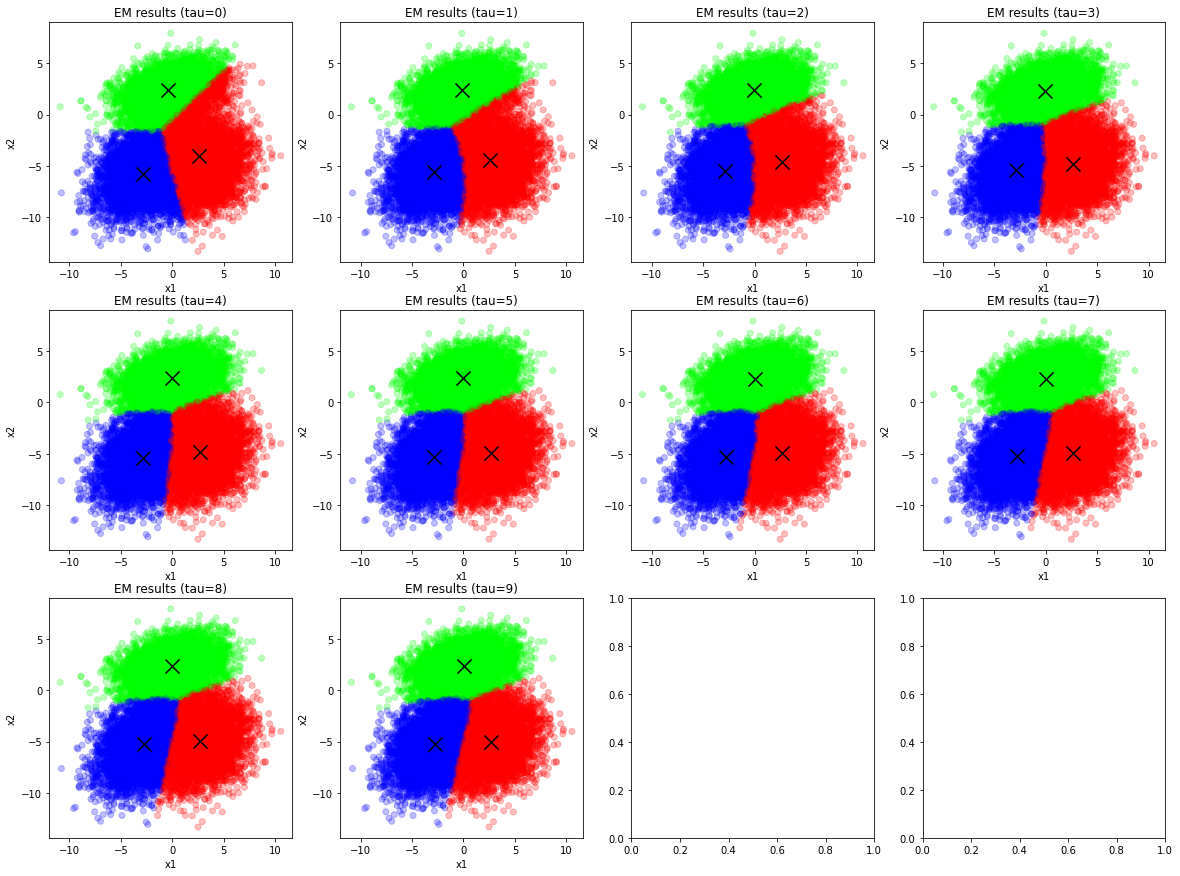

In [13]:
hard_gmm = HardGMM(K=3, epsilon=0.1,random_state=0)
hard_gmm.fit(X_train, verbose=True)
preds = hard_gmm.predict_proba(X_test)
fig, axs = plot_gmm(hard_gmm, X_train, gran=1)

iteration 0
iteration 1
Converged in 2 iterations


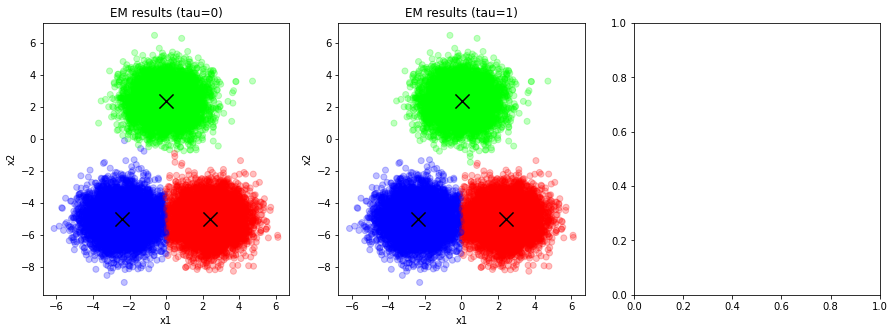

In [14]:
hard_gmm2 = HardGMM(K=3, epsilon=0.1,random_state=0)
hard_gmm2.fit(X_train_sep, verbose=True)
preds_sep = hard_gmm2.predict_proba(X_test_sep)
fig, axs = plot_gmm(hard_gmm2, X_train_sep, gran=1)

/tmp/ipykernel_106605/2746234602.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Xs = np.array([[X_train, X_test, X_train_sep, X_test_sep],
/tmp/ipykernel_106605/2746234602.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys = np.array([[y_train, y_test, y_train_sep, y_test_sep],
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to p

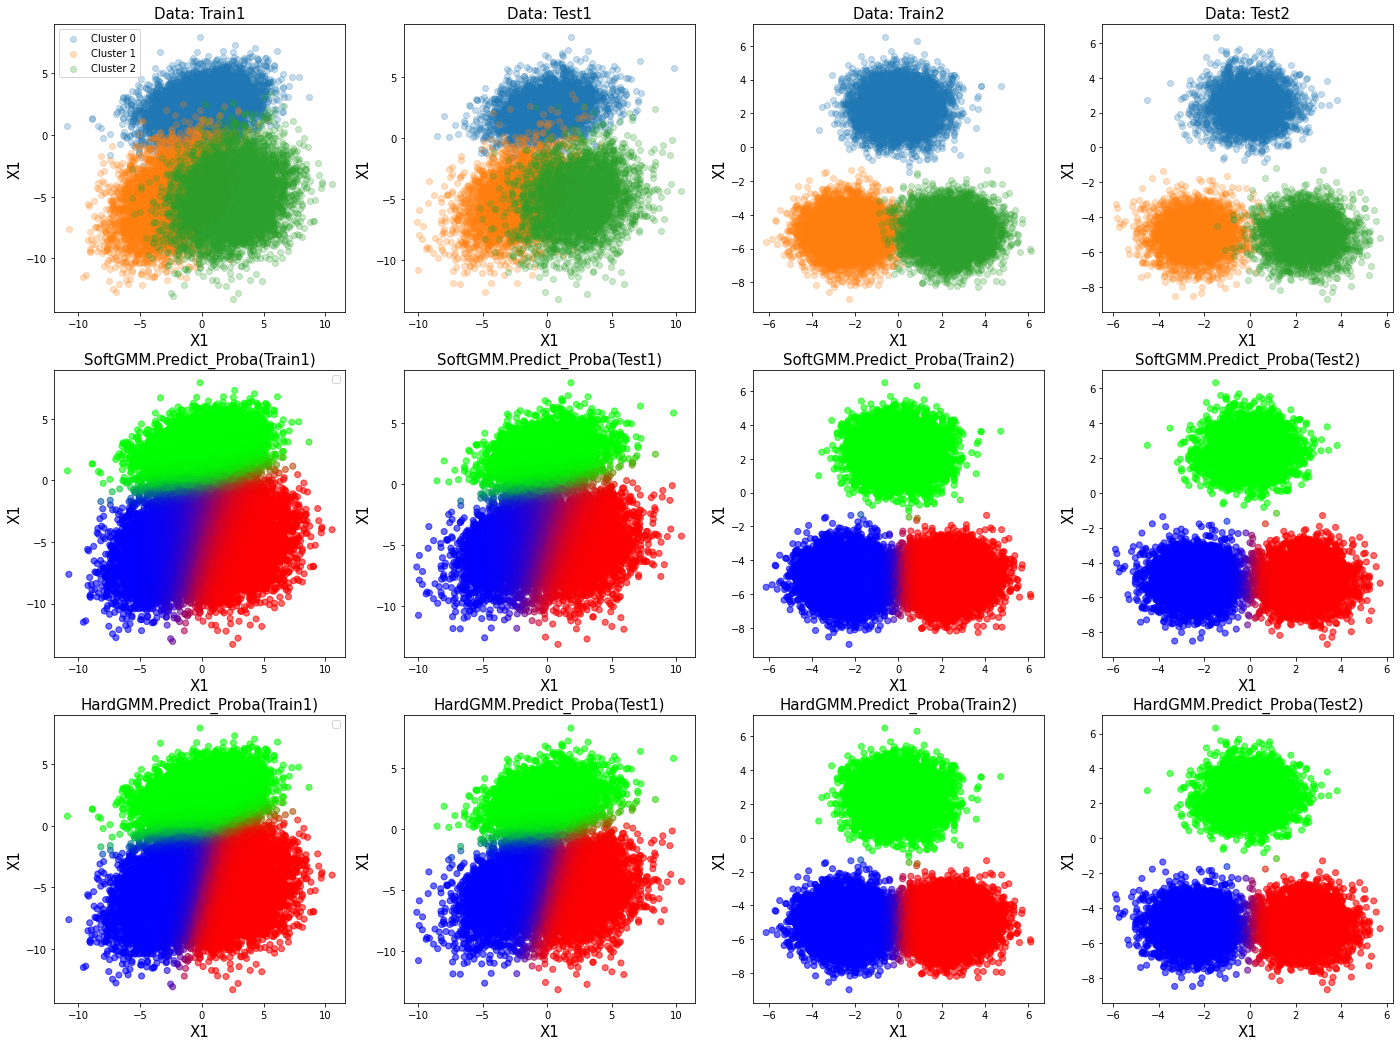

In [15]:
Xs = np.array([[X_train, X_test, X_train_sep, X_test_sep], 
               [X_train, X_test, X_train_sep, X_test_sep],
               [X_train, X_test, X_train_sep, X_test_sep],
               ])
ys = np.array([[y_train, y_test, y_train_sep, y_test_sep], 
               [soft_gmm.predict_proba(X_train), soft_gmm.predict_proba(X_test), soft_gmm2.predict_proba(X_train_sep), soft_gmm2.predict_proba(X_test_sep)],
               [hard_gmm.predict_proba(X_train), hard_gmm.predict_proba(X_test), hard_gmm2.predict_proba(X_train_sep), hard_gmm2.predict_proba(X_test_sep)],               
               ])
fig, axs = plot_data_vs_predictions(Xs, ys, np.array([['Data: Train1', 'Data: Test1', 'Data: Train2', 'Data: Test2'], 
                                      ['SoftGMM.Predict_Proba(Train1)', 'SoftGMM.Predict_Proba(Test1)', 'SoftGMM.Predict_Proba(Train2)', 'SoftGMM.Predict_Proba(Test2)'],
                                      ['HardGMM.Predict_Proba(Train1)', 'HardGMM.Predict_Proba(Test1)', 'HardGMM.Predict_Proba(Train2)', 'HardGMM.Predict_Proba(Test2)'],
                                      ]))
plt.show()

## Task G: Discussions

### Initialization Effect
In the above experiments, we used a simple but reasonably good initialization. Try some other initializations, reapet the experiments and study the results. For example, you can change

`Mu_hat = Mu_hat = X.sample(n=K).to_numpy()                   # randomly  choose K samples as cluster means `

to 

`Mu_hat = np.zeros((K,D)) # initialize all cluster means to the origin`

or

`Sigma_hat = np.array([np.eye(D) for _ in range(K)]) # initialize with identity covariance matrix`

to 

`Sigma_hat = np.array([make_spd_matrix(D) for _ in range(K)]) # initialize with random covariance matrix`

### Kmeans vs. GMM
Discuss the followings:
* What are the main differences between Kmeans clustering and (hard) GMM? Explain the assumptions behind each one of them, as well as their limitaitons and strength (**Hint:** Think about the covariance matrix!).
* How one can combine Kmeans and GMM to have the best of both worlds (**Hint:** Think about GMM initialization)?